<a href="https://colab.research.google.com/github/WillForkes/Arbitrage-Bet-Finder/blob/main/wine_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

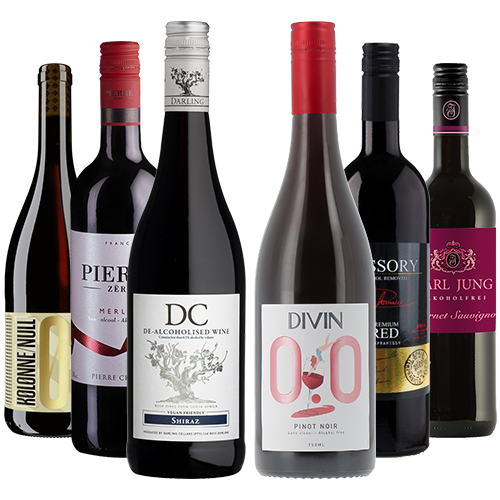

#Predicting Wine Quality With Machine Learning

# Load data and libaries
---

In this project, I use a variety of libaries to assist in producing an accurate machine learning model.

*   Numpy
*   Pandas
*   Matplotlib
*   Seaborn
*   Sklearn
*   Altair

This section also manages importing the datasets provided for red & white wine


In [ ]:
print("Importing dependancies...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV  # for splitting data
from sklearn.linear_model import LinearRegression  # for linear regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import altair as alt

print("All imports successful")

# Load datasets
red_wine = pd.read_csv('data/winequality-red.csv', sep=';')
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')

red_wine.isnull().sum()
white_wine.isnull().sum()

print("Data loaded successfully!")
print(f"Number of data points for red wines: {len(red_wine)}")
print(f"Number of data points for white wines: {len(white_wine)}")

Importing dependancies...
All imports successful
Data loaded successfully!
Number of data points for red wines: 1599
Number of data points for white wines: 4898


# Investigate distribution of quality scores within each dataset

---

This code calculates and visualizes the distribution of quality scores for red and white wines. A bar chart compares the frequency of each score, showing that most wines cluster around mid-range qualities (6–7), with fewer samples at the extremes. This insight helped guide threshold selection for later classification tasks.



Red Wine Quality Distribution:
 quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

White Wine Quality Distribution:
 quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


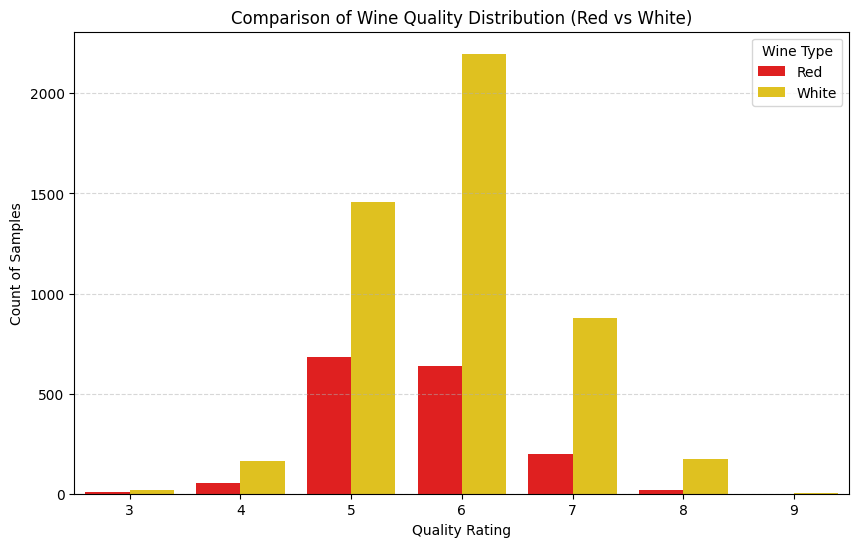

In [ ]:

print("Red Wine Quality Distribution:\n", red_wine['quality'].value_counts())
print("\nWhite Wine Quality Distribution:\n", white_wine['quality'].value_counts())

# Visualization of wine quality distribution
red_wine_quality = red_wine['quality'].value_counts().sort_index()
white_wine_quality = white_wine['quality'].value_counts().sort_index()

red_df = pd.DataFrame({'Quality': red_wine_quality.index, 'Count': red_wine_quality.values, 'Type': 'Red'})
white_df = pd.DataFrame({'Quality': white_wine_quality.index, 'Count': white_wine_quality.values, 'Type': 'White'})

wine_data = pd.concat([red_df, white_df])

plt.figure(figsize=(10, 6))
sns.barplot(x='Quality', y='Count', hue='Type', data=wine_data, palette=['red', 'gold'])

plt.title('Comparison of Wine Quality Distribution (Red vs White)')
plt.xlabel('Quality Rating')
plt.ylabel('Count of Samples')
plt.legend(title='Wine Type')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Alcohol Categorization
-------
This code categorizes wine samples into low, mid, or high alcohol content based on standard deviations from the mean. It’s applied to both red and white wine datasets to support analysis of alcohol’s effect on quality.

In [ ]:
# Discretise alcohol content into categories
def categorize_alcohol(wine_df):
    avg = wine_df['alcohol'].mean()
    std = wine_df['alcohol'].std()
    conditions = [
        wine_df['alcohol'] < (avg - std),
        wine_df['alcohol'].between((avg - std), (avg + std)),
        wine_df['alcohol'] > (avg + std)
    ]
    categories = [0, 1, 2]  # 0 = low, 1 = mid, 2 = high
    wine_df['alcohol_cat'] = np.select(conditions, categories, default=1)  # Default set to 'mid' (1)

# Apply to red and white wine datasets
categorize_alcohol(red_wine)
categorize_alcohol(white_wine)

print("Alcohol categories added successfully!")

Alcohol categories added successfully!


# Quality distribution after categorisation
---------
This visualization compares the distribution of alcohol content categories (low, mid, high) across red and white wines. It highlights how alcohol levels vary between wine types.

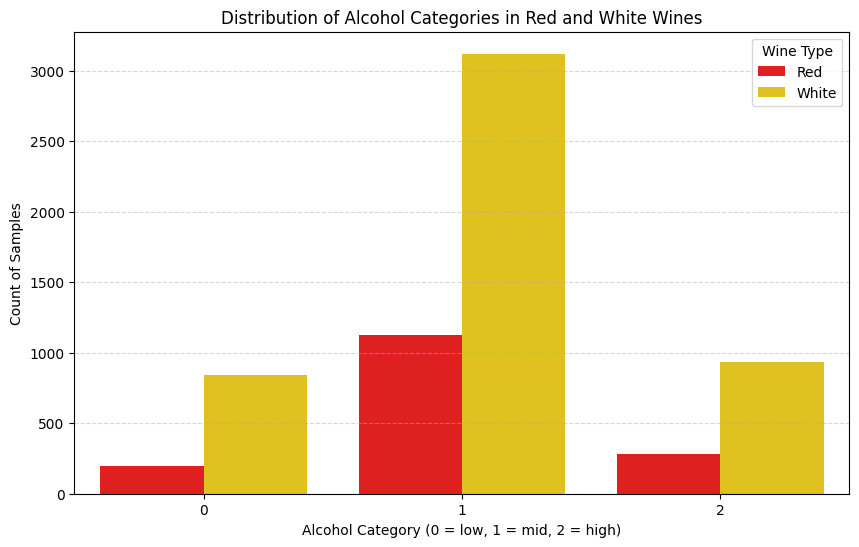

In [ ]:
# Combine red and white wine data for side-by-side visualization
red_wine['type'] = 'Red'
white_wine['type'] = 'White'
combined_wine = pd.concat([red_wine, white_wine])

# Visualize alcohol category distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='alcohol_cat', hue='type', data=combined_wine, palette=['red', 'gold'])
plt.title('Distribution of Alcohol Categories in Red and White Wines')
plt.xlabel('Alcohol Category (0 = low, 1 = mid, 2 = high)')
plt.ylabel('Count of Samples')
plt.legend(title='Wine Type')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Determine if wine is sweet
-----------
This section categorizes wines as sweet or dry based on the median residual sugar level for each type. The resulting bar charts show the proportion of sweet vs. dry wines in red and white varieties, providing insights into typical sugar content distributions.

<ipython-input-13-80ad320567f7>:24: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x='isSweet', y='percentage', hue='type', data=wine_counts_red, ax=axes[0], palette=['red', 'gold'])
<ipython-input-13-80ad320567f7>:32: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x='isSweet', y='percentage', hue='type', data=wine_counts_white, ax=axes[1], palette=['gold', 'red'])


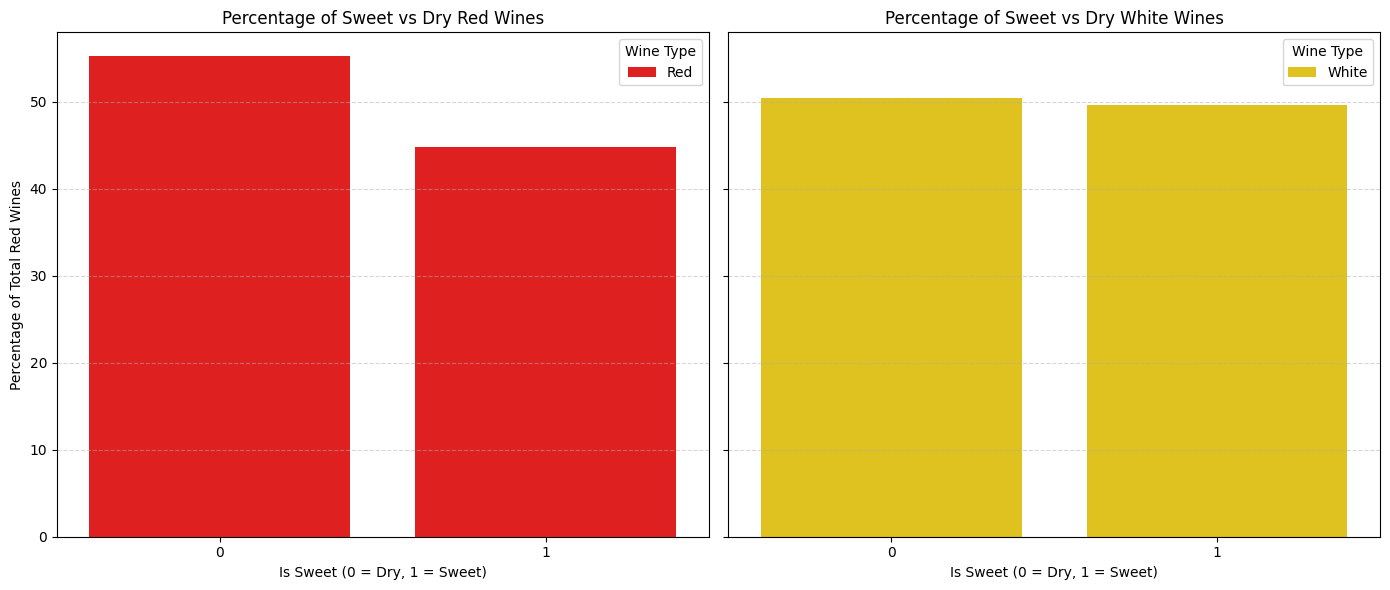

In [ ]:
# Determine suitable threshold to split data evenly for each wine type
threshold_red = red_wine['residual sugar'].median()
threshold_white = white_wine['residual sugar'].median()
threshold_combined_wine = combined_wine['residual sugar'].median()

# Add 'isSweet' variable
red_wine['isSweet'] = (red_wine['residual sugar'] > threshold_red).astype(int)
white_wine['isSweet'] = (white_wine['residual sugar'] > threshold_white).astype(int)
combined_wine['isSweet'] = (combined_wine['residual sugar'] > threshold_combined_wine).astype(int)

# Calculate percentage for each category
total_samples_red = len(red_wine)
total_samples_white = len(white_wine)

wine_counts_red = red_wine.groupby(['isSweet', 'type']).size().reset_index(name='count')
wine_counts_red['percentage'] = (wine_counts_red['count'] / total_samples_red) * 100
wine_counts_white = white_wine.groupby(['isSweet', 'type']).size().reset_index(name='count')
wine_counts_white['percentage'] = (wine_counts_white['count'] / total_samples_white) * 100

# Plotting two separate bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Red Wine Plot
sns.barplot(x='isSweet', y='percentage', hue='type', data=wine_counts_red, ax=axes[0], palette=['red', 'gold'])
axes[0].set_title('Percentage of Sweet vs Dry Red Wines')
axes[0].set_xlabel('Is Sweet (0 = Dry, 1 = Sweet)')
axes[0].set_ylabel('Percentage of Total Red Wines')
axes[0].legend(title='Wine Type')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# White Wine Plot
sns.barplot(x='isSweet', y='percentage', hue='type', data=wine_counts_white, ax=axes[1], palette=['gold', 'red'])
axes[1].set_title('Percentage of Sweet vs Dry White Wines')
axes[1].set_xlabel('Is Sweet (0 = Dry, 1 = Sweet)')
axes[1].set_ylabel('Percentage of Total White Wines')
axes[1].legend(title='Wine Type')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()

# Investigating the relationship between sweetness and percieved quality
----------
These plots compare the quality ratings of sweet and dry wines for both red and white types. By splitting the data on sweetness, we can observe whether sugar content correlates with perceived quality.

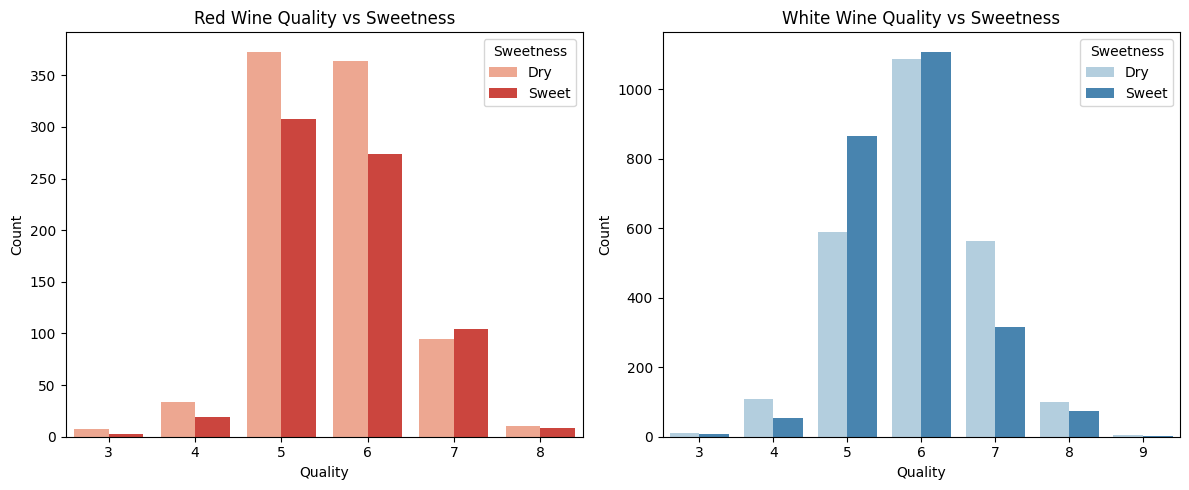

In [ ]:
# Distribution of quality for sweet vs dry wines (red)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='quality', hue='isSweet', data=red_wine, palette='Reds')
plt.title('Red Wine Quality vs Sweetness')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.legend(title='Sweetness', labels=['Dry', 'Sweet'])

# Distribution of quality for sweet vs dry wines (white)
plt.subplot(1, 2, 2)
sns.countplot(x='quality', hue='isSweet', data=white_wine, palette='Blues')
plt.title('White Wine Quality vs Sweetness')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.legend(title='Sweetness', labels=['Dry', 'Sweet'])

plt.tight_layout()
plt.show()

# Extension: Additional Descriptive Analysis
----------

Characterising quality with respect to isSweet and alcohol_cat

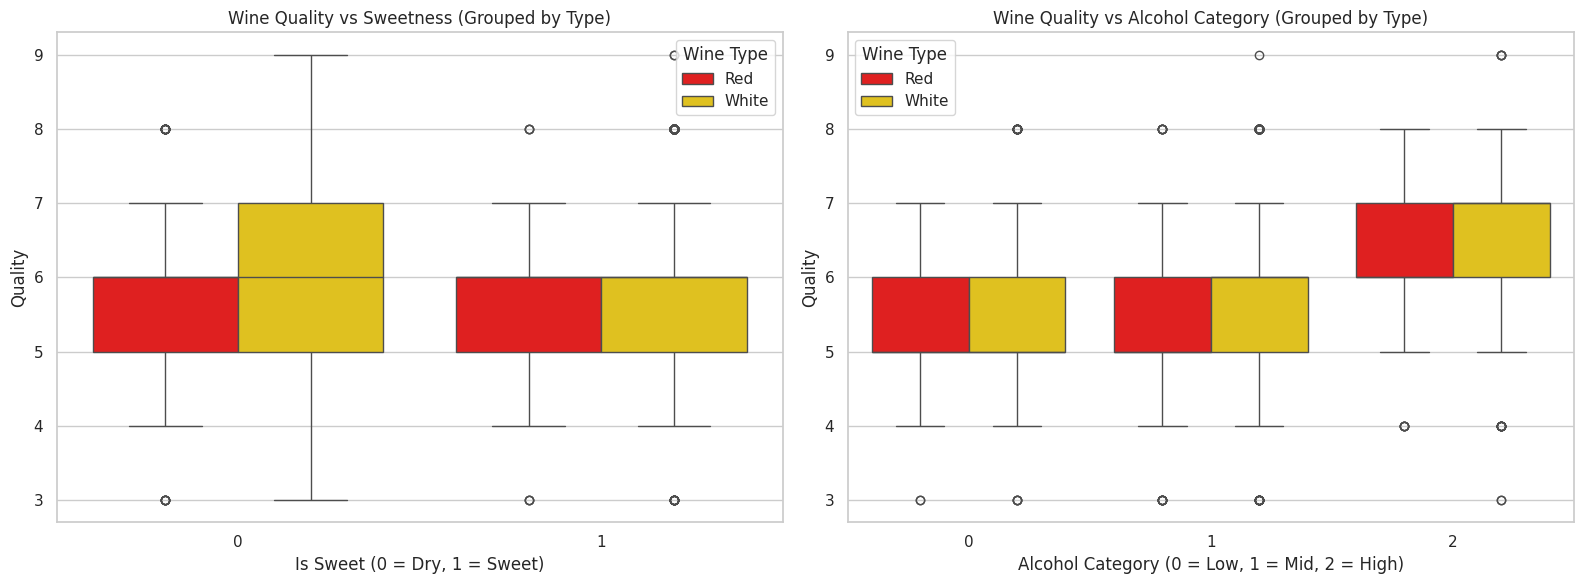

<ipython-input-21-bfc6623e9b68>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='alcohol_cat', y='quality', data=combined_wine, palette='pastel')


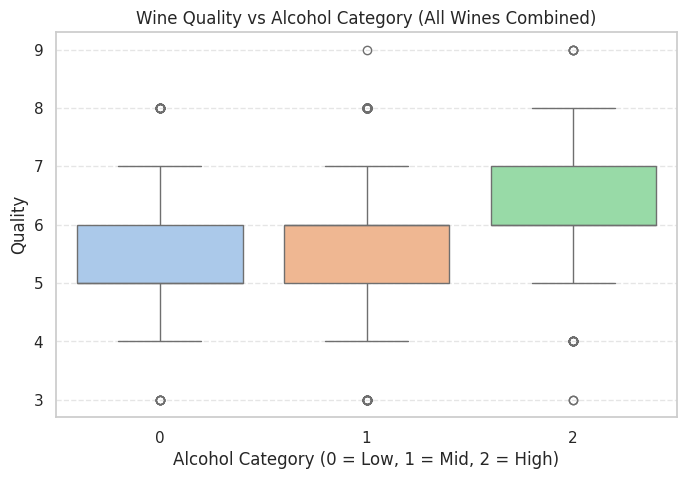

In [ ]:
# Boxplots to analyse quality distribution with respect to sweetness and alcohol category
plt.figure(figsize=(16, 6))

# Quality vs Sweetness
plt.subplot(1, 2, 1)
sns.boxplot(x='isSweet', y='quality', hue='type', data=combined_wine, palette=['red', 'gold'])
plt.title('Wine Quality vs Sweetness (Grouped by Type)')
plt.xlabel('Is Sweet (0 = Dry, 1 = Sweet)')
plt.ylabel('Quality')
plt.legend(title='Wine Type')

# Quality vs Alcohol Category
plt.subplot(1, 2, 2)
sns.boxplot(x='alcohol_cat', y='quality', hue='type', data=combined_wine, palette=['red', 'gold'])
plt.title('Wine Quality vs Alcohol Category (Grouped by Type)')
plt.xlabel('Alcohol Category (0 = Low, 1 = Mid, 2 = High)')
plt.ylabel('Quality')
plt.legend(title='Wine Type')

plt.tight_layout()
plt.show()

# Quality vs Alcohol Category, disregarding wine type
plt.figure(figsize=(8, 5))
sns.boxplot(x='alcohol_cat', y='quality', data=combined_wine, palette='pastel')
plt.title('Wine Quality vs Alcohol Category (All Wines Combined)')
plt.xlabel('Alcohol Category (0 = Low, 1 = Mid, 2 = High)')
plt.ylabel('Quality')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Analyse Correlations Between Variable
---------
This heatmap shows the Spearman correlation between numerical features in the combined wine dataset. Spearman is ideal for detecting non-linear relationships and is less affected by outliers.

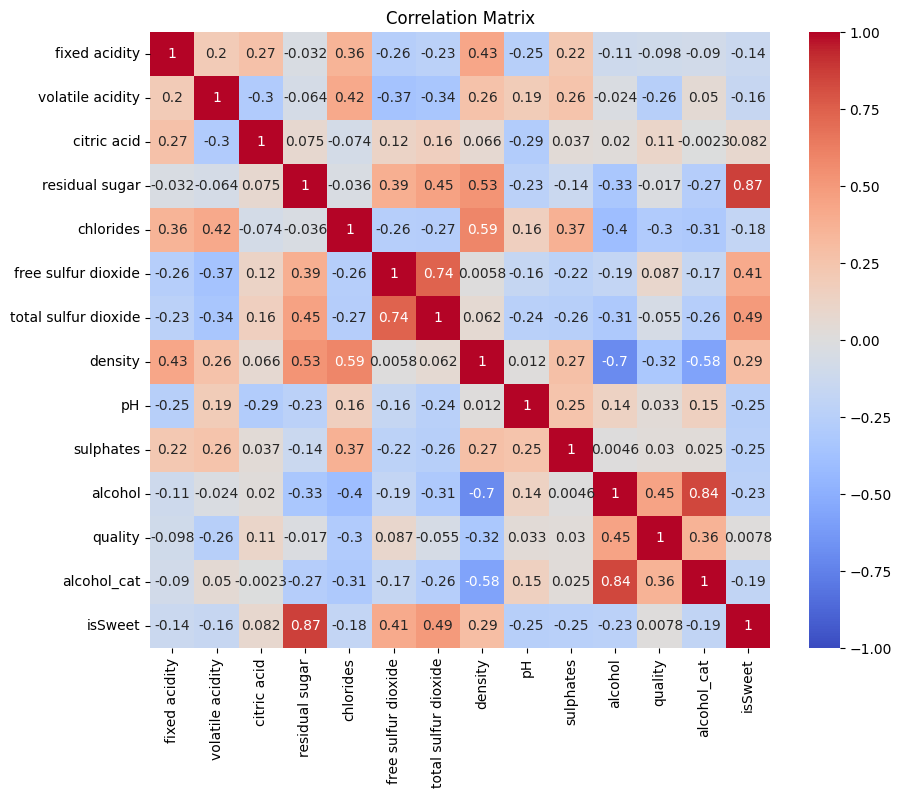

In [ ]:
# Select only numeric columns (correlation matrix's don't work with strings)
combined_wine_numeric_only = combined_wine.select_dtypes(include=['float64', 'int64'])

# Using Spearman metric
# Handles non-linear relationships effectively.
# Less sensitive to outliers compared to Pearson.
# Suitable for ordinal data like quality ratings.

# Correlation matrix
correlation_matrix = combined_wine_numeric_only.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# K-Fold Cross Validation - Binary Classification
-------

Here we are using the K-Fold cross validation method to train a model on binary classification. In our use case we're representing either low quality or high quality (0 or 1)


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import pandas as pd

random_state = 5

# Convert wine quality to binary classification
def prepare_data_with_threshold(df, threshold=5):
    df = df.copy()
    print(f"Using threshold: if quality < {threshold} then LOW, else HIGH")
    df['quality_binary'] = df['quality'].apply(lambda x: 0 if x < threshold else 1)
    features = df.drop(columns=['quality', 'type', 'quality_binary'])
    target = df['quality_binary']
    return features, target

def evaluate_model(X, y, label):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Get class distribution as percentages
    class_distribution = y_train.value_counts(normalize=True).sort_index()
    percent_0 = class_distribution.get(0, 0) * 100
    percent_1 = class_distribution.get(1, 0) * 100

    # Print in formatted string
    print(f"Class distribution (low quality, high quality): {percent_0:.0f}% / {percent_1:.0f}%")

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        random_state=random_state,
        class_weight='balanced'
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    f1_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf,
                                scoring=make_scorer(f1_score, average='binary'))

    y_train_np = np.array(y_train)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

    print(f"=> 5 Folds completed.")
    print(f"=> Average F1 Score: {f1_scores.mean():.4f}%")
    print(f"=> F1 Score Standard Deviation: {f1_scores.std():.4f}\n-----")

# Separate red and white wine
data_red = red_wine
data_white = white_wine
data_all = combined_wine

# Run evaluations
print(f"\n========= RED WINE =========")
evaluate_model(*prepare_data_with_threshold(data_red, 5), label="Red")
evaluate_model(*prepare_data_with_threshold(data_red, 6), label="Red")
evaluate_model(*prepare_data_with_threshold(data_red, 7), label="Red")

print(f"\n\n\n========= WHITE WINE =========")
evaluate_model(*prepare_data_with_threshold(data_white, 5), label="White")
evaluate_model(*prepare_data_with_threshold(data_white, 6), label="White")
evaluate_model(*prepare_data_with_threshold(data_white, 7), label="White")

print(f"\n\n\n========= ALL WINE =========")
evaluate_model(*prepare_data_with_threshold(data_all, 5), label="Combined")
evaluate_model(*prepare_data_with_threshold(data_all, 6), label="Combined")
evaluate_model(*prepare_data_with_threshold(data_all, 7), label="Combined")



========= RED WINE =========
Using threshold: if quality < 5 then LOW, else HIGH
Class distribution (low quality, high quality): 4% / 96%
=> 5 Folds completed.
=> Average F1 Score: 0.9664%
=> F1 Score Standard Deviation: 0.0095
-----
Using threshold: if quality < 6 then LOW, else HIGH
Class distribution (low quality, high quality): 46% / 54%
=> 5 Folds completed.
=> Average F1 Score: 0.7638%
=> F1 Score Standard Deviation: 0.0054
-----
Using threshold: if quality < 7 then LOW, else HIGH
Class distribution (low quality, high quality): 87% / 13%
=> 5 Folds completed.
=> Average F1 Score: 0.5955%
=> F1 Score Standard Deviation: 0.0487
-----



========= WHITE WINE =========
Using threshold: if quality < 5 then LOW, else HIGH
Class distribution (low quality, high quality): 4% / 96%
=> 5 Folds completed.
=> Average F1 Score: 0.9555%
=> F1 Score Standard Deviation: 0.0036
-----
Using threshold: if quality < 6 then LOW, else HIGH
Class distribution (low quality, high quality): 34% / 66%
=> 5

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def evaluate_regression_model(X, y, label):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=5,
        random_state=random_state
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    neg_mse_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = (-neg_mse_scores) ** 0.5

    # Train on full training set and evaluate on test set
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)

    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    print(f"=> [REGRESSION] {label} Wine")
    print(f"=> Average RMSE (5-fold CV): {rmse_scores.mean():.4f}")
    print(f"=> RMSE Std Dev (5-fold CV): {rmse_scores.std():.4f}")
    print(f"=> RMSE on Test Set: {test_rmse:.4f}")
    r2 = r2_score(y_test, y_pred_test)
    print(f"=> R² on Test Set: {r2:.4f}   (0 = best)\n-----")

# Prepare regression targets
def prepare_regression_data(df):
    df = df.copy()
    features = df.drop(columns=['quality', 'type'])
    target = df['quality']
    return features, target

# Run regression evaluations
print(f"\n========= RED WINE (Regression) =========")
evaluate_regression_model(*prepare_regression_data(red_wine), label="Red")

print(f"\n========= WHITE WINE (Regression) =========")
evaluate_regression_model(*prepare_regression_data(white_wine), label="White")

print(f"\n========= COMBINED WINE (Regression) =========")
evaluate_regression_model(*prepare_regression_data(combined_wine), label="Combined")


========= RED WINE (Regression) =========
=> [REGRESSION] Red Wine
=> Average RMSE (5-fold CV): 0.6326
=> RMSE Std Dev (5-fold CV): 0.0275
=> RMSE on Test Set: 0.6153
=> R² on Test Set: 0.4167   (0 = best)
-----

========= WHITE WINE (Regression) =========
=> [REGRESSION] White Wine
=> Average RMSE (5-fold CV): 0.7246
=> RMSE Std Dev (5-fold CV): 0.0164
=> RMSE on Test Set: 0.6966
=> R² on Test Set: 0.3261   (0 = best)
-----

========= COMBINED WINE (Regression) =========
=> [REGRESSION] Combined Wine
=> Average RMSE (5-fold CV): 0.7172
=> RMSE Std Dev (5-fold CV): 0.0100
=> RMSE on Test Set: 0.7040
=> R² on Test Set: 0.3710   (0 = best)
-----


# Visualizing result data

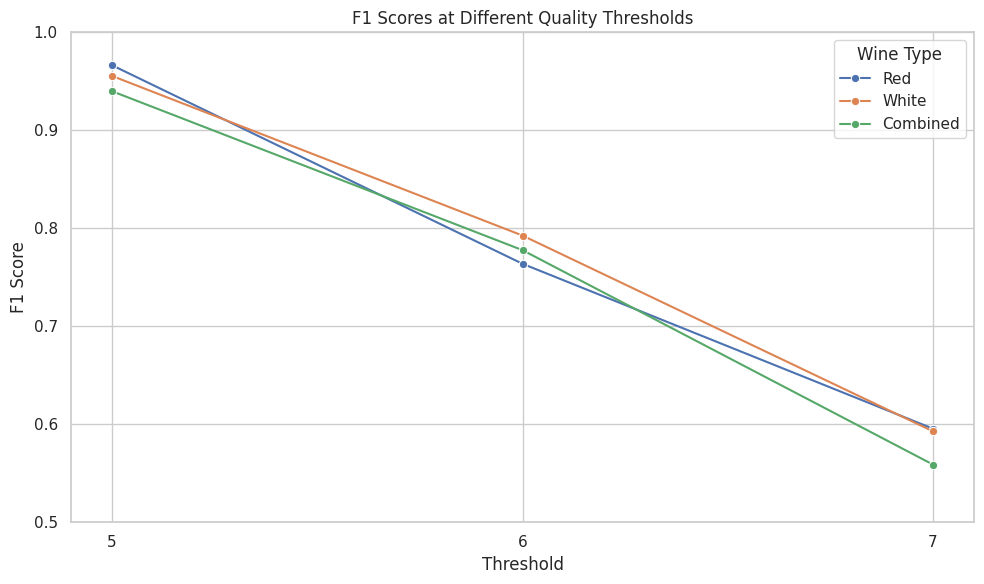

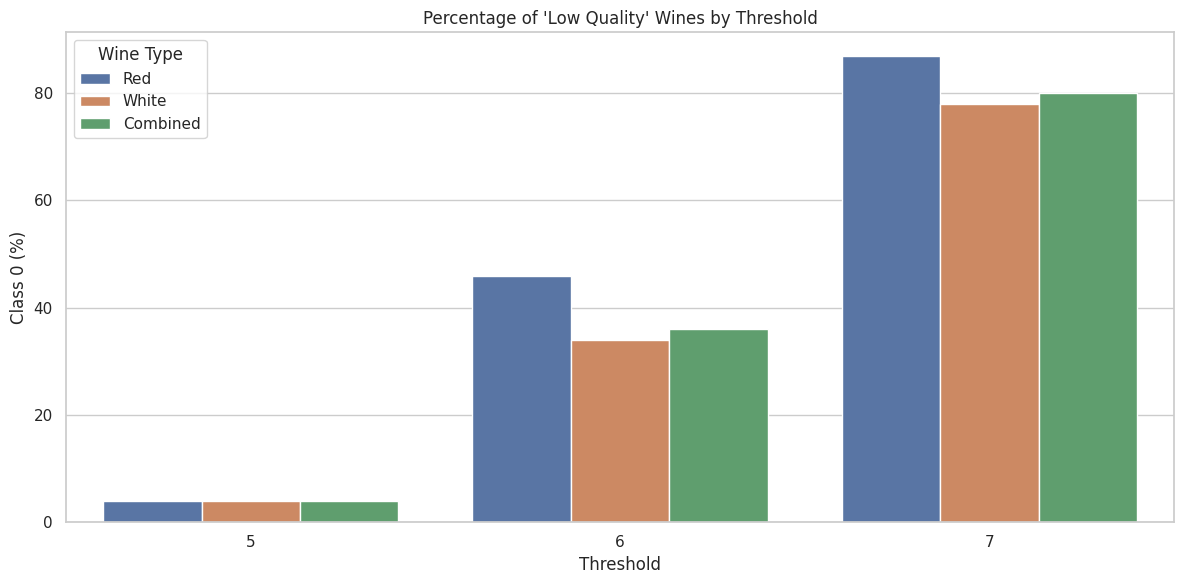

<ipython-input-19-4ed4d2f8384e>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=regression_data, x="Wine Type", y="Test RMSE", palette="muted")


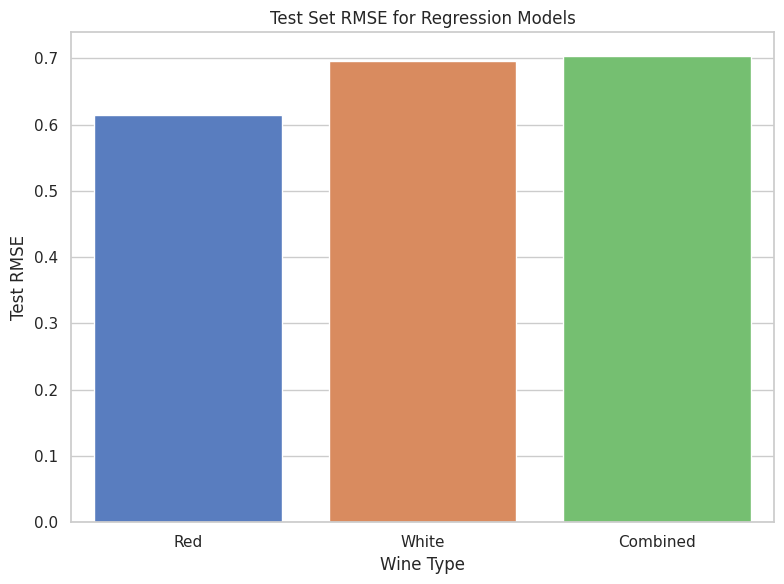

<ipython-input-19-4ed4d2f8384e>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=regression_data, x="Wine Type", y="R² Score", palette="pastel")


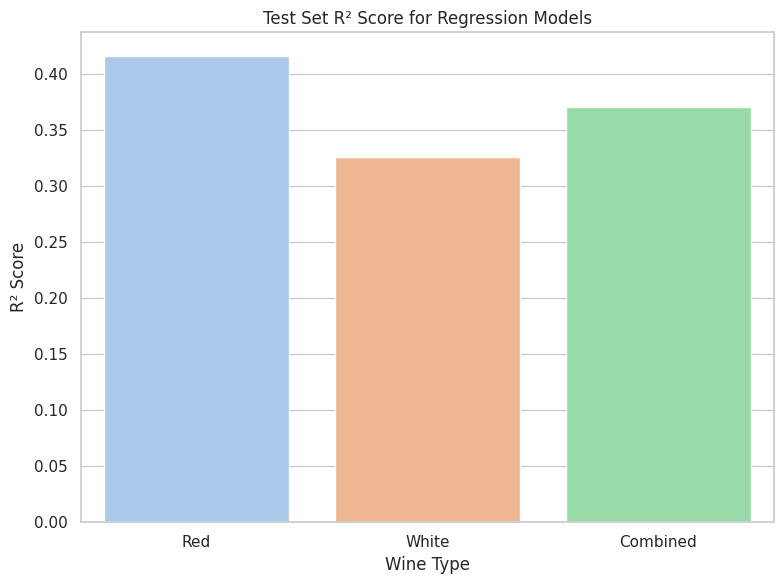

In [ ]:
# Set style
sns.set(style="whitegrid")

# Data for classification F1 scores
f1_data = pd.DataFrame({
    "Threshold": [5, 6, 7] * 3,
    "F1 Score": [
        0.9664, 0.7638, 0.5955,  # Red
        0.9555, 0.7926, 0.5928,  # White
        0.9399, 0.7777, 0.5589   # Combined
    ],
    "Wine Type": ["Red"] * 3 + ["White"] * 3 + ["Combined"] * 3
})

# Data for class distribution
distribution_data = pd.DataFrame({
    "Threshold": [5, 6, 7] * 3,
    "Class 0 (%)": [
        4, 46, 87,  # Red
        4, 34, 78,  # White
        4, 36, 80   # Combined
    ],
    "Class 1 (%)": [
        96, 54, 13,  # Red
        96, 66, 22,  # White
        96, 64, 20   # Combined
    ],
    "Wine Type": ["Red"] * 3 + ["White"] * 3 + ["Combined"] * 3
})

# Data for regression
regression_data = pd.DataFrame({
    "Wine Type": ["Red", "White", "Combined"],
    "Test RMSE": [0.6153, 0.6966, 0.7042],
    "R² Score": [0.4167, 0.3261, 0.3706]
})

# Plotting F1 Scores by Threshold
plt.figure(figsize=(10, 6))
sns.lineplot(data=f1_data, x="Threshold", y="F1 Score", hue="Wine Type", marker="o")
plt.title("F1 Scores at Different Quality Thresholds")
plt.ylim(0.5, 1.0)
plt.xticks([5, 6, 7])
plt.tight_layout()
plt.show()

# Plotting Class Distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=distribution_data, x="Threshold", y="Class 0 (%)", hue="Wine Type")
plt.title("Percentage of 'Low Quality' Wines by Threshold")
plt.tight_layout()
plt.show()

# Regression: Test RMSE
plt.figure(figsize=(8, 6))
sns.barplot(data=regression_data, x="Wine Type", y="Test RMSE", palette="muted")
plt.title("Test Set RMSE for Regression Models")
plt.tight_layout()
plt.show()

# Regression: R² Score
plt.figure(figsize=(8, 6))
sns.barplot(data=regression_data, x="Wine Type", y="R² Score", palette="pastel")
plt.title("Test Set R² Score for Regression Models")
plt.tight_layout()
plt.show()